In [1]:
from orbit_generation.visualize import visualize_static_orbits
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.experiment import get_experiment_parameters
from orbit_generation.propagation import jacobi_constant
from orbit_generation.constants import EM_MU

In [2]:
import numpy as np
import os
import pandas as pd

# Load

In [3]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../experiments'
experiment_folder = r'../experiments/experiment_1'
experiment_id = int(experiment_folder[-1])

In [4]:
images_folder = os.path.join(experiment_folder, 'images')
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
initial_conditions_file = os.path.join(experiment_folder, f'exp{experiment_id}_corrected_initial_conditions.npy')
generated_data_file = os.path.join(experiment_folder, f'exp{experiment_id}_propagated_corrected_ICs.npy')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')

# Dataset

In [5]:
params=get_experiment_parameters(experiments_folder=experiments_folder, experiment_id=experiment_id)

data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 300)

In [6]:
transposed_orbits = np.transpose(data, (0, 2, 1))

if transposed_orbits.shape[2] == 7:
    full_data = transposed_orbits[:,:,1:]
else:
    full_data = transposed_orbits

full_data.shape

(45211, 300, 6)

In [7]:
results = np.array([jacobi_constant(full_data[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
orbit_df['calculated_jacobi'] = results

In [8]:
orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


# Refined Orbits

In [9]:
initial_conditions = np.load(initial_conditions_file)
columns= ['id','old_period', 'new_period', 'iterations_convergence','error','pos_x0','pos_y0','pos_z0','vel_x0','vel_y0','vel_z0']
synthetic_orbit_df = pd.DataFrame(initial_conditions, columns=columns)
generated_data = np.load(generated_data_file)
generated_data.shape

(51, 300, 7)

In [10]:
if generated_data.shape[2] == 7:
    display_generation = generated_data[:,:,1:]
else:
    display_generation = generated_data

display_generation.shape

(51, 300, 6)

In [11]:
new_jacobis = np.array([jacobi_constant(display_generation[i][0], EM_MU)[0] for i in range(display_generation.shape[0])])
synthetic_orbit_df['calculated_jacobi'] = new_jacobis
synthetic_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)

In [12]:
synthetic_orbit_df.head()

,id,old_period,period,iterations_convergence,error,pos_x0,pos_y0,pos_z0,vel_x0,vel_y0,vel_z0,calculated_jacobi
0,5.0,6.222030,6.192932,9.0,6.301578e-12,0.874645,-0.111746,-2.606991e-01,-0.183580,-0.364638,-8.920535e-01,2.028652
1,7.0,6.791755,6.334867,20.0,4.204361e-14,-6.770056,-23.728922,-1.030387e-20,-23.535336,6.714824,3.379070e-25,9.987551
2,11.0,6.336819,6.546722,7.0,4.462795e-10,0.561438,-1.094286,-3.753770e-15,-0.373137,-0.229283,7.069713e-14,2.952673
3,12.0,10.498634,12.298088,12.0,4.171158e-12,0.943796,-1.140043,1.203071e-13,-0.577731,-0.291908,-5.175010e-15,3.132707
4,13.0,6.416141,4.694308,9.0,4.954805e-12,1.277904,1.616904,2.503308e-13,2.164505,-1.709546,1.794688e-13,-2.378271


# Compare

In [13]:
import numpy as np
from scipy.spatial import cKDTree

def calculate_closest_distances(orbit_df, synthetic_orbit_df, features):
    """
    Calculate the distance from each point in synthetic_orbit_df to the closest point in orbit_df
    based on specified features.
    
    Parameters:
    - orbit_df: DataFrame containing the training data.
    - synthetic_orbit_df: DataFrame containing the synthetic data.
    - features: List of features (columns) to use for calculating the distances.
    
    Returns:
    - distances: A NumPy array of the minimum distances from each synthetic point to the nearest orbit point.
    """
    # Extract the relevant features from both DataFrames
    orbit_points = orbit_df[features].values
    synthetic_points = synthetic_orbit_df[features].values

    # Create a KDTree for efficient nearest-neighbor search in orbit_df
    tree = cKDTree(orbit_points)

    # Query the KDTree with the synthetic points to find the distance to the nearest orbit point
    distances, _ = tree.query(synthetic_points, k=1)

    return distances

In [14]:
# Define the features to be used for distance calculation
features = ['period', 'calculated_jacobi']

# Calculate the distances
distances = calculate_closest_distances(orbit_df, synthetic_orbit_df, features)

In [15]:
distances

array([1.96579923e-03, 6.20301433e+00, 1.46932169e-04, 1.33146316e-01,
       2.04140737e+00, 5.57622252e-04, 4.05379785e-01, 2.17106063e-03,
       3.26056626e-04, 3.14391588e-03, 9.42017231e-04, 2.70551863e-04,
       9.79291980e-04, 7.67721062e-01, 1.63317533e-04, 1.55021030e-03,
       4.90524642e-04, 5.33537679e-05, 2.68252861e-03, 2.96337684e-01,
       2.55996979e-04, 6.81400957e-06, 9.18469587e-04, 3.97233722e-04,
       3.30145740e-04, 2.36794784e-04, 3.30037010e-04, 3.23099875e-04,
       2.38670531e-02, 5.21113006e-04, 2.39917978e-03, 4.03698734e-04,
       1.35511611e-03, 1.38815176e-04, 4.30061439e-04, 1.38969134e-04,
       5.31932634e-04, 2.97966571e-03, 1.91136550e-04, 2.99338308e-04,
       1.42114101e-04, 1.05235764e-04, 7.59101819e-04, 2.25569366e-04,
       9.81583921e-04, 5.47639640e-06, 7.31224326e-04, 8.28424844e-03,
       1.14376300e-03, 4.09491174e+00, 1.20640765e-03])

In [16]:
import matplotlib.pyplot as plt

def plot_comparison(orbit_df, synthetic_orbit_df):
    """
    Function to create a scatter plot comparing 'period' and 'calculated_jacobi'
    between two DataFrames and plot the index of points in synthetic_orbit_df.
    
    Parameters:
    - orbit_df: DataFrame containing 'period' and 'calculated_jacobi' columns
    - synthetic_orbit_df: DataFrame containing 'period' and 'calculated_jacobi' columns
    """
    plt.figure(figsize=(10, 6))

    # Plot for orbit_df
    plt.scatter(orbit_df['period'], orbit_df['calculated_jacobi'], color='blue', label='orbit_df', marker='o')

    # Plot for synthetic_orbit_df
    plt.scatter(synthetic_orbit_df['period'], synthetic_orbit_df['calculated_jacobi'], color='red', label='synthetic_orbit_df', marker='x')

    # Annotate the points in synthetic_orbit_df with their indices
    for i in synthetic_orbit_df.index:
        plt.text(synthetic_orbit_df['period'].loc[i], 
                 synthetic_orbit_df['calculated_jacobi'].loc[i], 
                 str(int(i)), 
                 fontsize=9, color='black', ha='right')

    # Add labels and title
    plt.xlabel('Period')
    plt.ylabel('Calculated Jacobi')
    plt.title('Comparison of Features Between Two DataFrames')
    plt.legend()  # Add legend to distinguish between the groups

    # Display the plot
    plt.grid(True)
    plt.show()

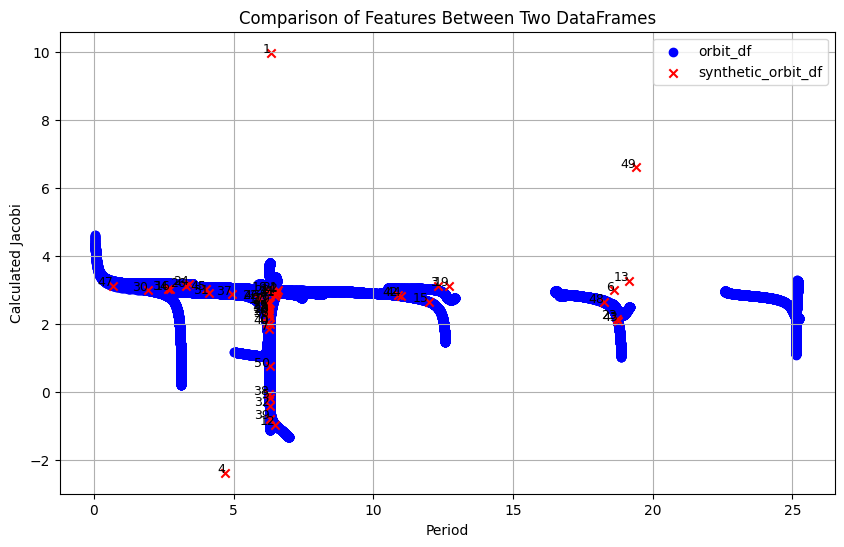

In [17]:
plot_comparison(orbit_df, synthetic_orbit_df)

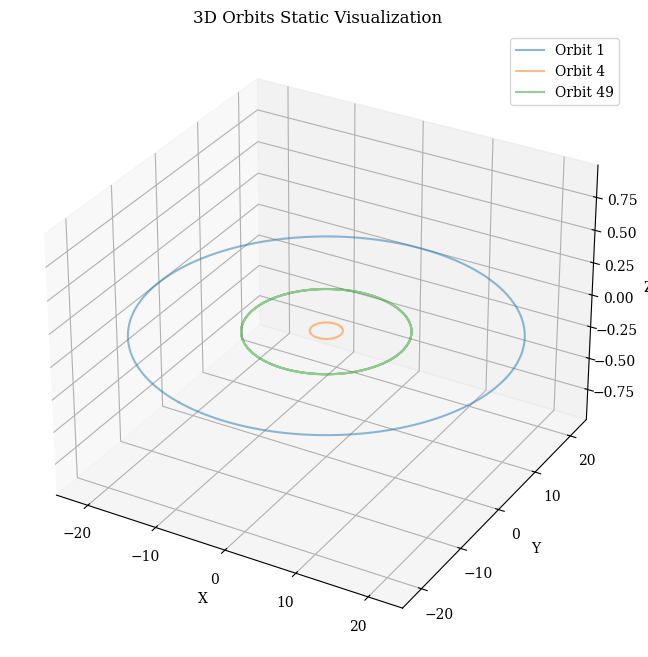

In [19]:
visualize_static_orbits(np.transpose(display_generation, (0, 2, 1)), orbit_indices=[1,4,49])